## Run sdk and dispaly video 


In [11]:

from metavision_core.event_io import EventsIterator
from metavision_sdk_core import PeriodicFrameGenerationAlgorithm
from metavision_sdk_ui import EventLoop, BaseWindow, Window, UIAction, UIKeyEvent

path = "../data/195_falling_particles.raw"

# Events iterator on Camera or RAW file
mv_iterator = EventsIterator(input_path=path, delta_t=1000)
height, width = mv_iterator.get_size()  # Camera Geometry
        
# Event Frame Generator
event_frame_gen = PeriodicFrameGenerationAlgorithm(width, height, accumulation_time_us=15)

# Window - Graphical User Interface
with Window(title="Metavision SDK Get Started", width=width, height=height, mode=BaseWindow.RenderMode.BGR) as window:
    def on_cd_frame_cb(ts, cd_frame):
        window.show(cd_frame)

    event_frame_gen.set_output_callback(on_cd_frame_cb)

    def keyboard_cb(key, scancode, action, mods):
        if action != UIAction.RELEASE:
            return
        if key == UIKeyEvent.KEY_ESCAPE or key == UIKeyEvent.KEY_Q:
            window.set_close_flag()

    window.set_keyboard_callback(keyboard_cb)

    global_counter = 0  # This will track how many events we processed
    global_max_t = 0  # This will track the highest timestamp we processed

    # Process events
    for evs in mv_iterator:
        EventLoop.poll_and_dispatch()

        event_frame_gen.process_events(evs)
        print("----- New event buffer! -----")
        if evs.size == 0:
            print("The current event buffer is empty.")
        else:
            min_t = evs['t'][0]   # Get the timestamp of the first event of this callback
            max_t = evs['t'][-1]  # Get the timestamp of the last event of this callback
            global_max_t = max_t  # Events are ordered by timestamp, so the current last event has the highest timestamp

            counter = evs.size  # Local counter
            global_counter += counter  # Increase global counter

            print(f"There were {counter} events in this event buffer.")
            print(f"The envs size is  {evs.size}")
            print(evs)
            print(f"There were {global_counter} total events up to now.")
            print(f"The current event buffer included events from {min_t} to {max_t} microseconds.")
            print("----- End of the event buffer! -----")

# Print the global statistics
duration_seconds = global_max_t / 1.0e6
print(f"There were {global_counter} events in total.")
print(f"The total duration was {duration_seconds:.2f} seconds.")
if duration_seconds >= 1:  # No need to print this statistics if the video was too short
    print(f"There were {global_counter / duration_seconds :.2f} events per second on average.")

----- New event buffer! -----
There were 21000 events in this event buffer.
The envs size is  21000
[(256,  1, 0,   0) ( 58,  1, 0,   0) ( 56,  0, 0,   4) ...
 (261, 20, 1, 999) (553, 26, 0, 999) (268, 54, 0, 999)]
There were 21000 total events up to now.
The current event buffer included events from 0 to 999 microseconds.
----- End of the event buffer! -----
----- New event buffer! -----
There were 63843 events in this event buffer.
The envs size is  63843
[(525, 17, 0, 1000) ( 56,  7, 1, 1000) (526, 14, 0, 1000) ...
 ( 72, 17, 1, 1999) (338, 12, 1, 1999) (104, 18, 0, 1999)]
There were 84843 total events up to now.
The current event buffer included events from 1000 to 1999 microseconds.
----- End of the event buffer! -----
----- New event buffer! -----
There were 114562 events in this event buffer.
The envs size is  114562
[(412, 40, 1, 2000) ( 24, 32, 0, 2000) (106, 31, 0, 2000) ...
 (354, 46, 1, 2999) (215, 35, 1, 2999) ( 34, 98, 0, 2999)]
There were 199405 total events up to now.
T

KeyboardInterrupt: 

## Manually colapse the events in images 

Collapse the events in the frames to get the most active pixels and get an 'artificial brightnest' of the image 


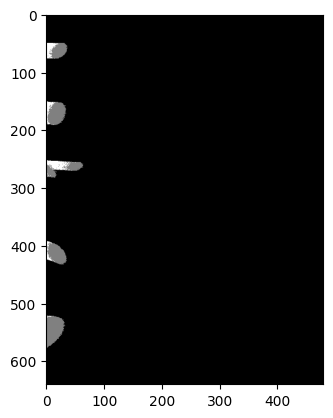

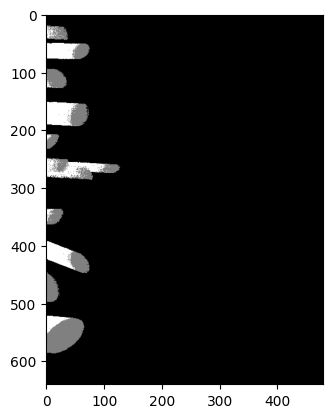

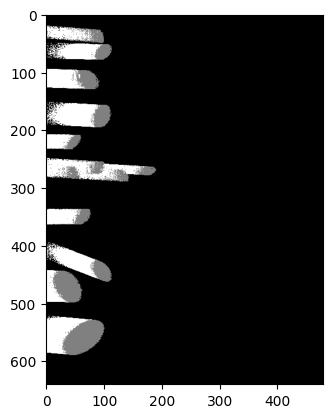

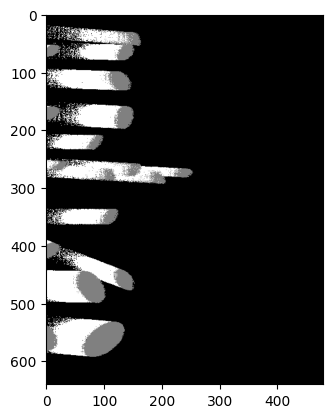

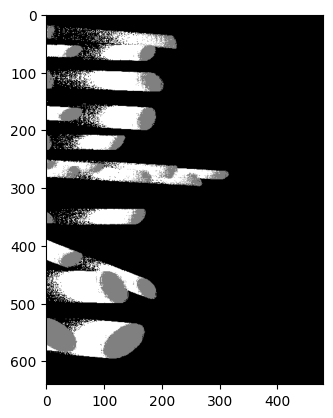

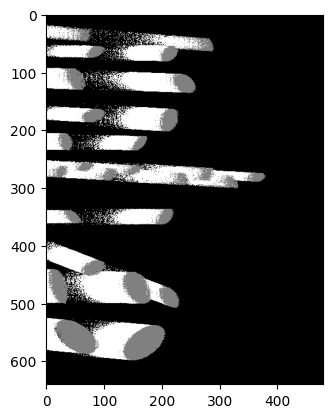

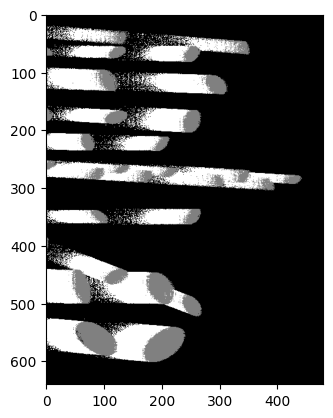

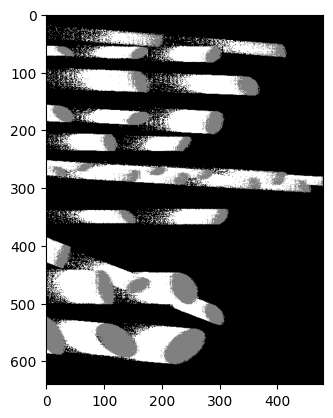

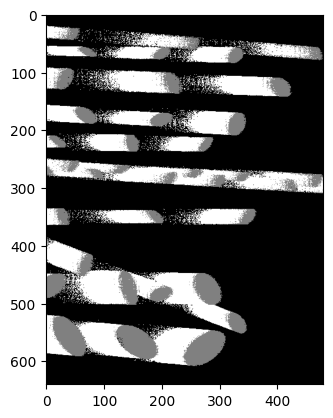

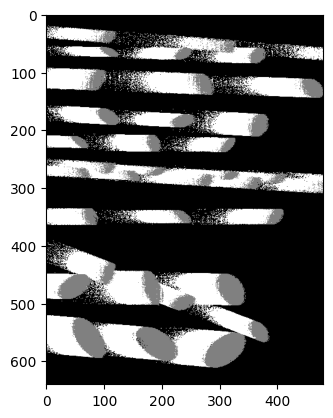

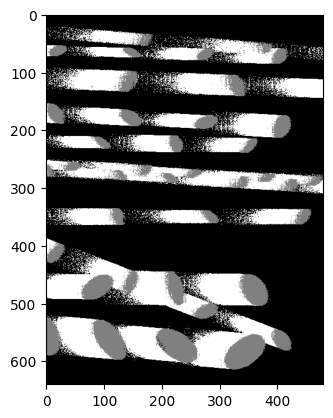

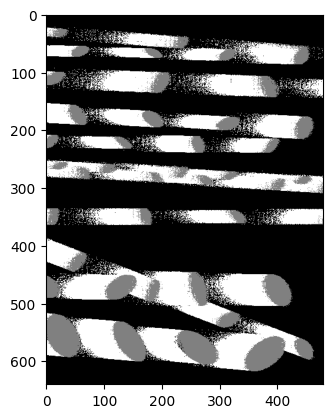

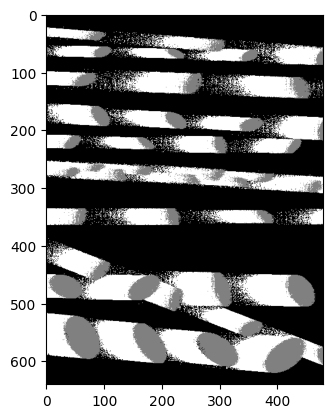

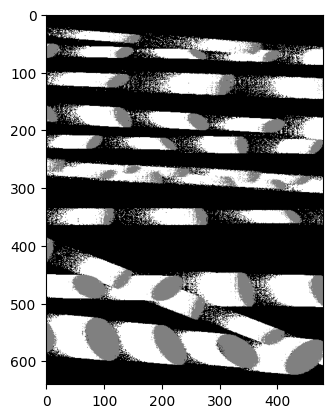

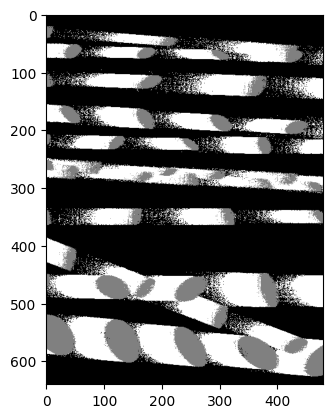

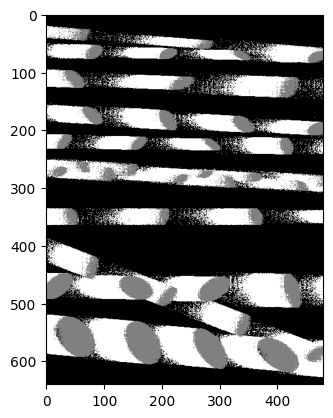

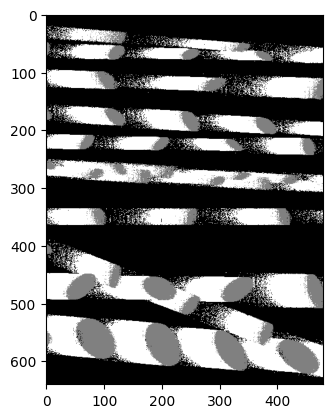

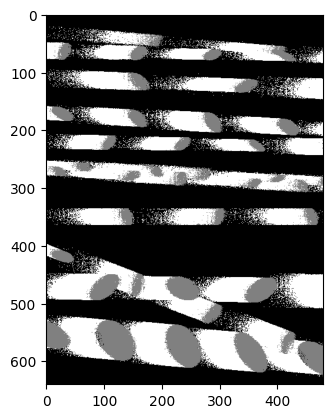

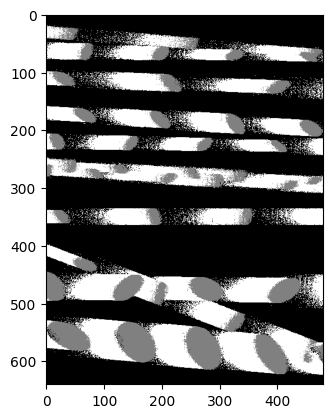

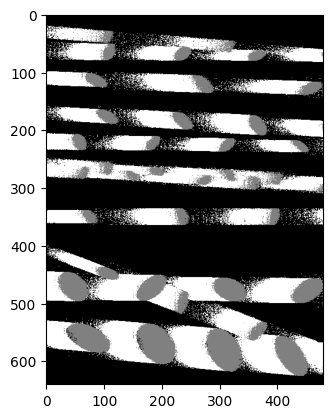

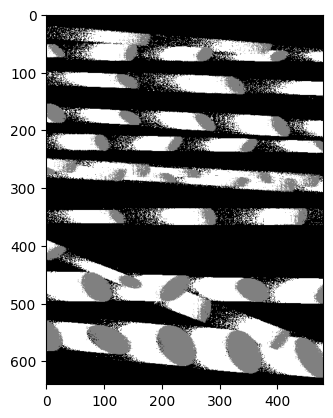

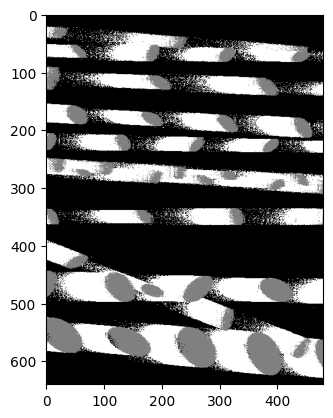

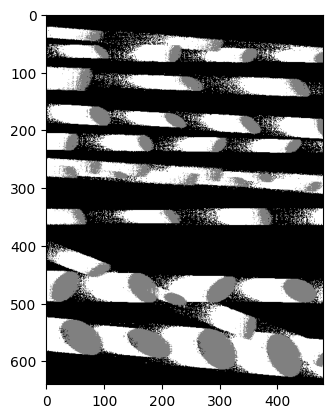

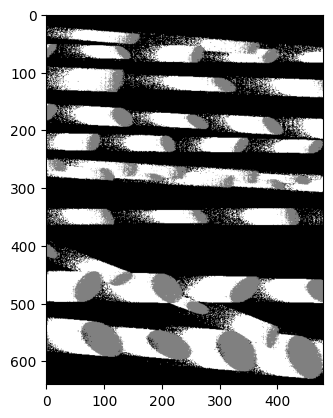

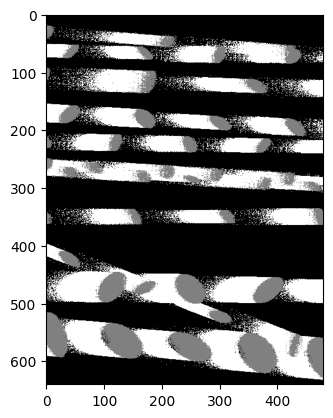

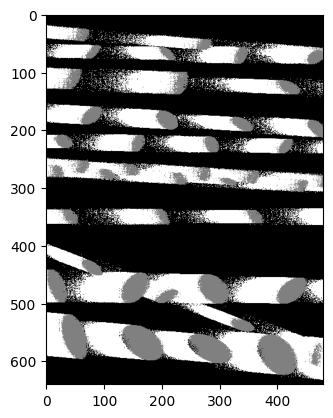

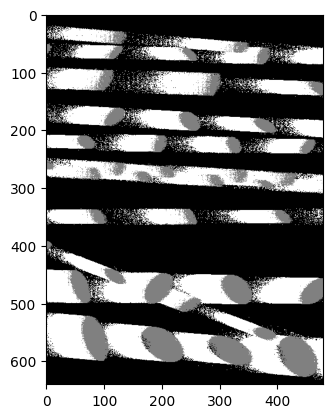

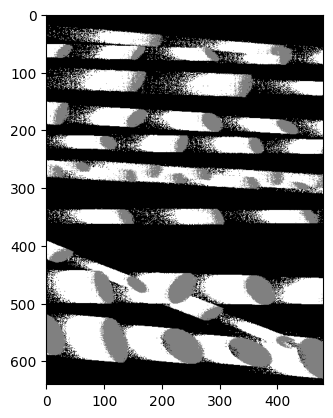

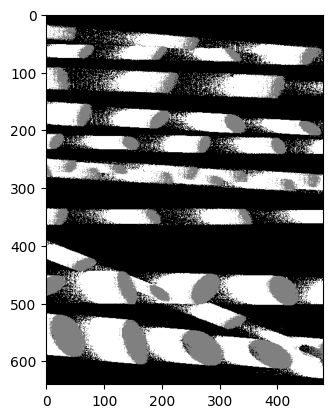

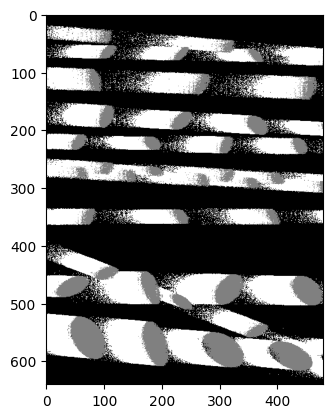

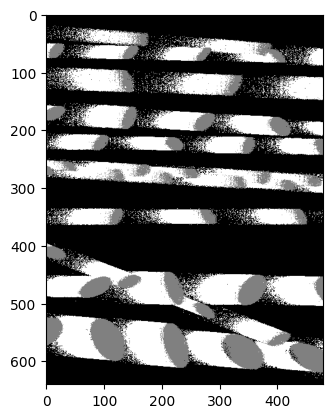

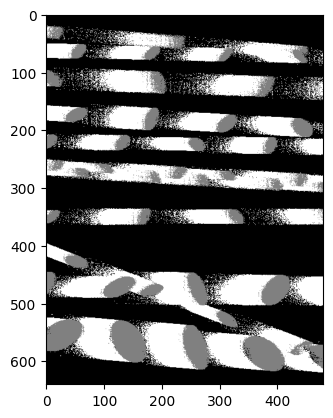

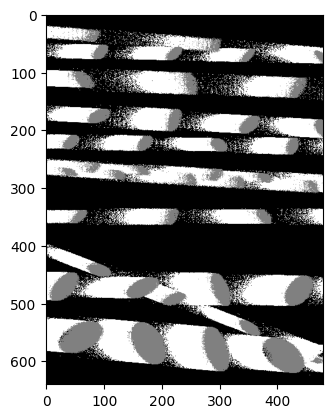

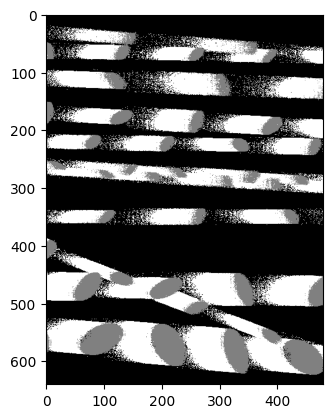

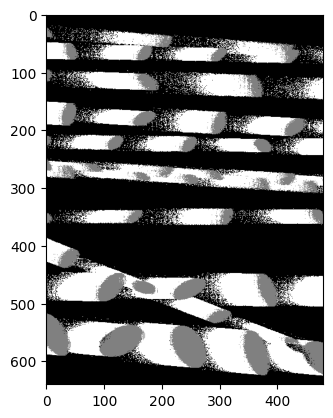

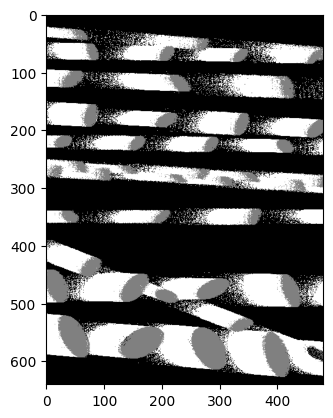

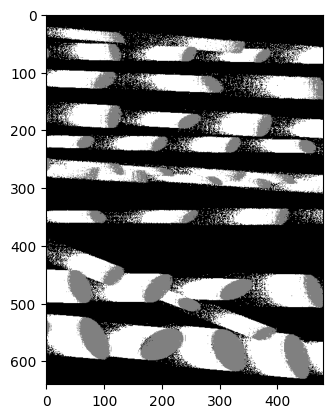

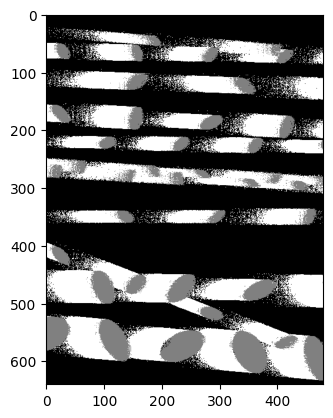

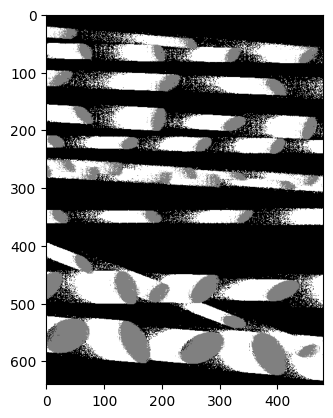

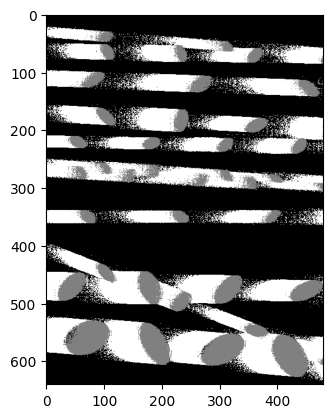

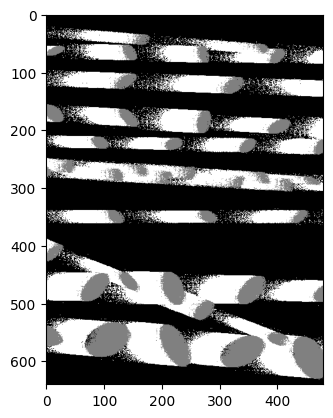

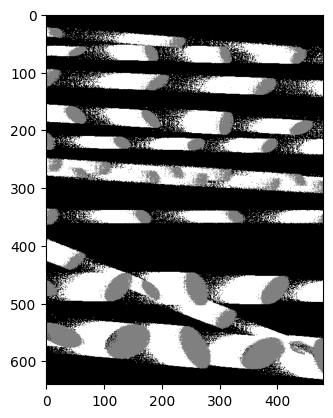

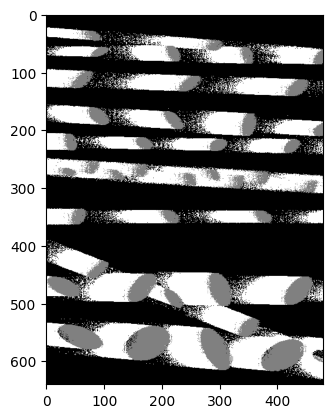

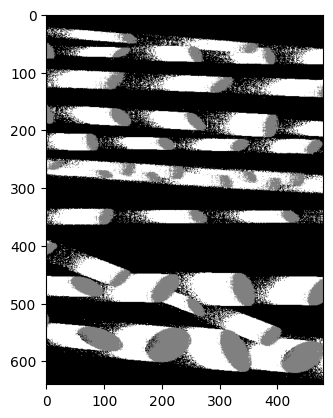

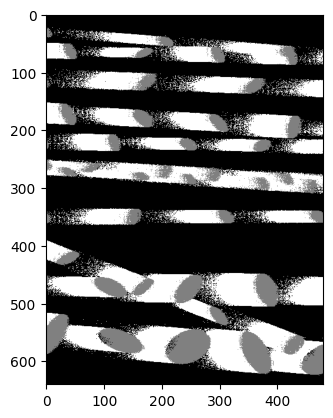

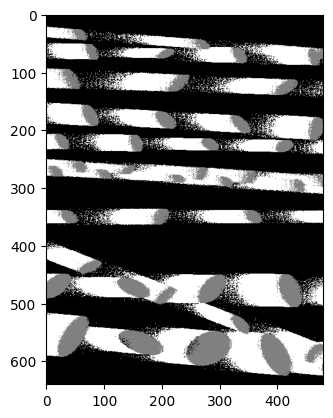

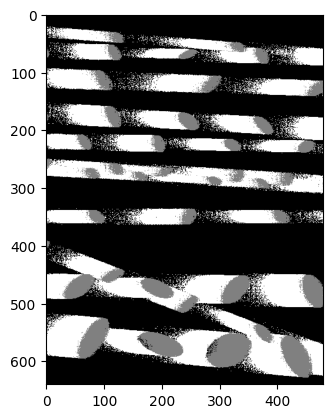

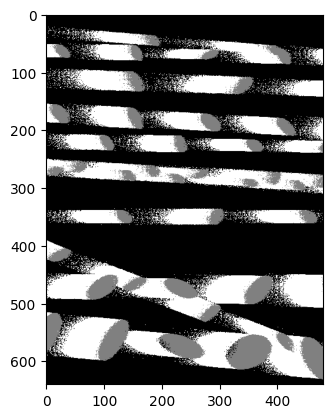

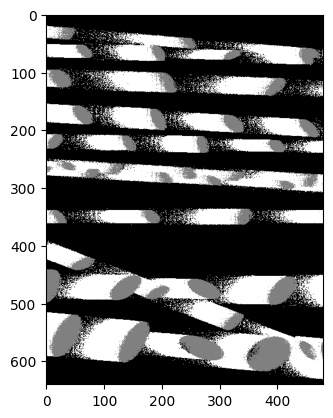

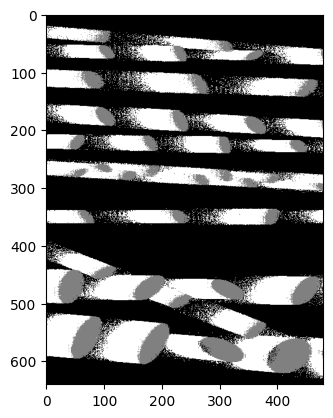

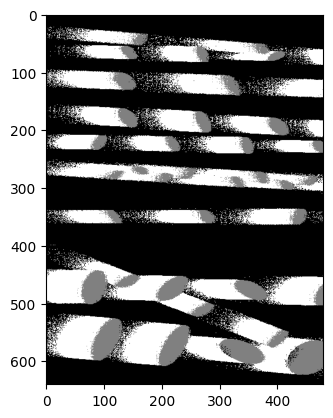

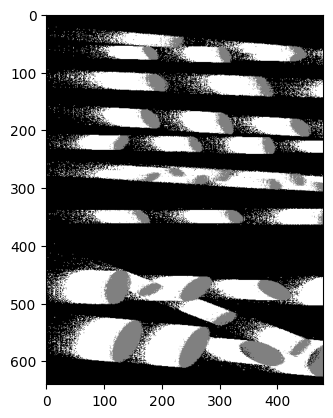

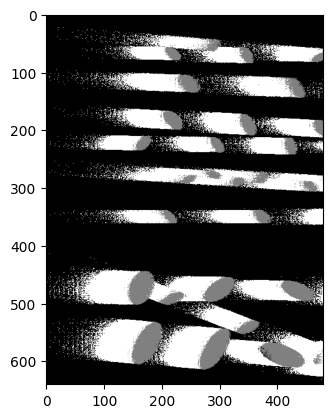

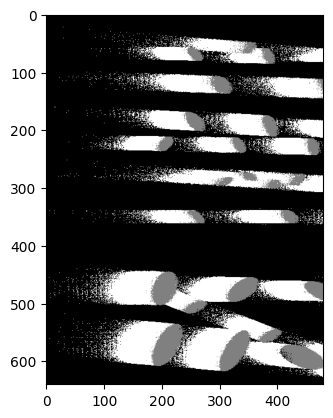

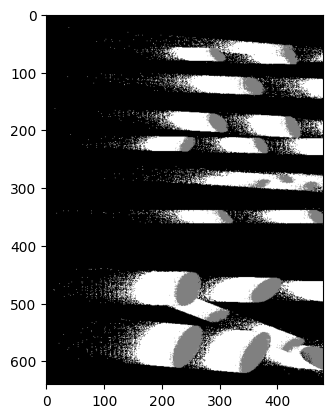

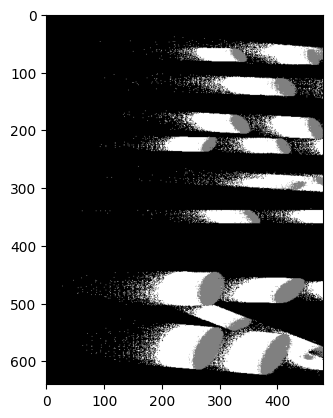

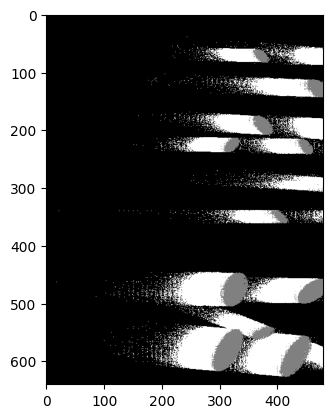

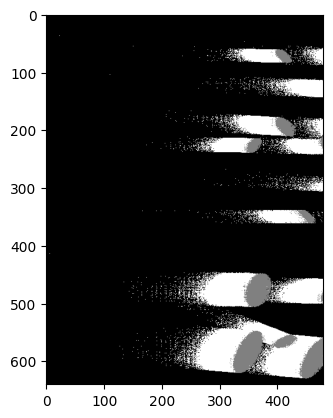

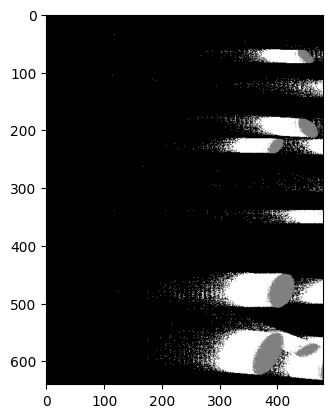

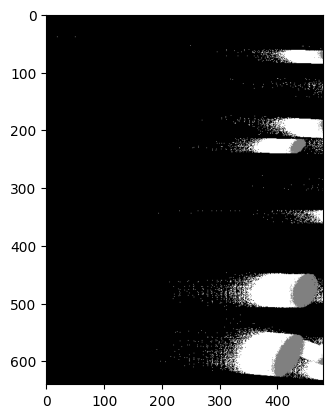

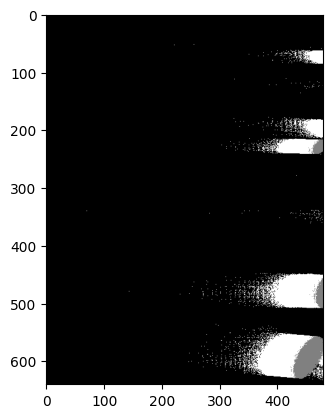

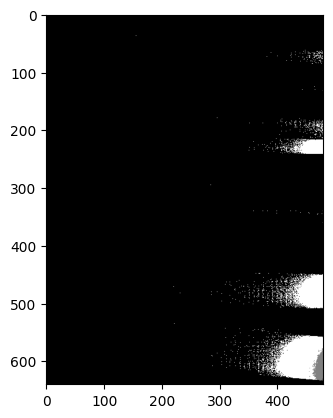

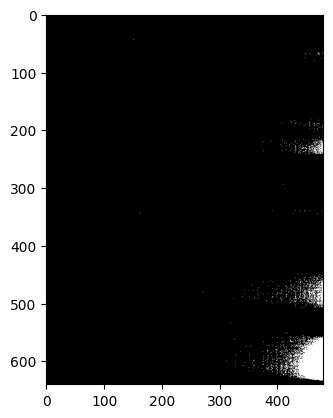

In [31]:
from metavision_core.event_io import EventsIterator
import numpy as np
import matplotlib.pyplot as plt

path = "../data/195_falling_particles.raw"
mv_iterator = EventsIterator(input_path=path, delta_t=1000)

for evs in mv_iterator:
    # Create an array that transforms the events into an image
    height, width = mv_iterator.get_size()  # Camera Geometry, WHY DOES THIS NOT WORK?


    # Get the indices from ev and create an array with the pixel values
    img = np.full((width, height), -1)
    for ev in evs:
        img[ev[0], ev[1]] = ev[2]

    plot_image(img)


In [2]:
from metavision_core.event_io import EventsIterator
import numpy as np
import matplotlib.pyplot as plt

path = "../data/195_falling_particles.raw"
mv_iterator = EventsIterator(input_path=path, delta_t=1000)

def events_colapsing(evs, width, height):
    '''
    Create an array that colapse the events into an image
    
    Parameters
    ----------  
    evs : array
        Array of events
    width : int
        Width of the image
    height : int
        Height of the image

    Returns
    -------
    img : array
        Array of the image

    '''

    # Get the indices from ev and create an array with the pixel values
    img = np.full((width, height), 0)
    for ev in evs:
        if ev[2] == 0:
            img[ev[0], ev[1]] += 1

    return img

frames = []
for evs in mv_iterator:
    # Create an array that transforms the events into an image
    height, width = mv_iterator.get_size()  # Camera Geometry, WHY DOES THIS NOT WORK?

    # Get the indices from ev and create an array with the pixel values
    img = events_colapsing(evs, width, height)
            
    frames.append(img)

In [3]:
import numpy as np

def plot_image(img):
    # Create figure and axes 
    fig, ax = plt.subplots()
    # Display the image
    ax.imshow(img, cmap='gray')

    # # Show the plot
    plt.show()

    # Pause for 0.01 seconds
    plt.pause(0.01)
    
def treshold_filter(img, treshold):
    '''
    Deletes the pixels with a value below the treshold.

    Parameters
    ----------
    img : numpy array
        Image to be filtered.
    treshold : int
        Treshold value.

    Returns
    -------
    filtered_img : numpy array
        Filtered image.
    '''
    
    # Create a copy of the input image
    filtered_img = np.copy(img)

    # Filter the image with a threshold
    for i in range(filtered_img.shape[0]):
        for j in range(filtered_img.shape[1]):
            if filtered_img[i, j] < treshold:
                filtered_img[i, j] = 0

    return filtered_img

def max_value_cluster(img, pixel_range, n_clusters, iterations=1):

    '''
    Creates a list of clusters searching the the maximun pixel value and performing the center of mass 
    of the pixels around it. The pixels that are part of the cluster are deleted and the process is repeated.

    Parameters
    ----------
    img : numpy array
        Image to be filtered.
    pixel_range : int
        Range of pixels to be considered around the maximun pixel value to perform the center of mass 
        (clustering).
    n_clusters : int
        Number of clusters to be found.
    iterations : int, optional
        Number of times the clustering is performed. When iterating the clusters are ordered by the cluster 
        mass and the index used a preliminary stimations . The default is 1.

    Returns
    -------
    clusters : list
        List of clusters. Each cluster is a list with the following structure:
            [ [x_pixel, y_pixel], cluster comulative mass, inital cluster position [x_max, y_max] ]    
    
    '''
    # Create a copy of the input image
    filtered_img = np.copy(img)

    clusters = []

    for i in range(n_clusters):
        # Get the maximun pixel value
        max_index = np.unravel_index(np.argmax(filtered_img), filtered_img.shape)

        cluster_x = 0
        cluster_y = 0
        cluster_mass = 0
        # Performs the clustering on the pixel range around the maximun pixel value
        for i in range(-pixel_range, pixel_range):
            for j in range(-pixel_range, pixel_range):
                if max_index[0]+i < filtered_img.shape[0] and max_index[1]+j < filtered_img.shape[1]:
                    
                    cluster_x += filtered_img[max_index[0] + i , max_index[1] + j ] * i
                    cluster_y += filtered_img[max_index[0] + i , max_index[1] + j ] * j
                    cluster_mass += filtered_img[max_index[0] + i , max_index[1] + j ] 

                    # Delete the pixels that are part of the cluster to find another maximun
                    filtered_img[max_index[0] + i , max_index[1] + j ] = 0

        #CHECK 
        # plot_image(filtered_img)
        if cluster_mass != 0:
            clusters.append([ np.round(max_index + [cluster_x, cluster_y]/cluster_mass).astype(int), 
                            cluster_mass, 
                            np.array(max_index)]) 

    return clusters

def index_cluster(img, pixel_range, clusters_index):

    '''
    Creates a list of clusters performing the center of mass of the pixels around the index given.
    to it. The pixels that are part of the cluster are deleted and the process is repeated. For better
    perfomace the clusters should be ordered by the cluster mass.
    
    Parameters
    ----------
    img : numpy array
        Image to be filtered.
    pixel_range : int
        Range of pixels to be considered around the maximun pixel value to perform the center of mass 
        (clustering).
    
    clusters_index : list of arrays
        Array with the index of the clusters to be computed.
    

    Returns
    -------
    clusters : list
        List of clusters. Each cluster is a list with the following structure:
            [ [x_pixel, y_pixel], cluster comulative mass, inital cluster position [x_max, y_max] ]    
    
    '''
    # Create a copy of the input image
    filtered_img = np.copy(img)

    clusters = []

    for i in range(clusters_index.shape[0]):
        # Get the maximun pixel value
        cluster_index = clusters_index[i]

        cluster_x = 0
        cluster_y = 0
        cluster_mass = 0
        # Performs the clustering on the pixel range around the maximun pixel value
        for i in range(-pixel_range, pixel_range):
            for j in range(-pixel_range, pixel_range):
                if cluster_index[0]+i < filtered_img.shape[0] and cluster_index[1]+j < filtered_img.shape[1]:

                    cluster_x += filtered_img[cluster_index[0] + i , cluster_index[1] + j ] * i
                    cluster_y += filtered_img[cluster_index[0] + i , cluster_index[1] + j ] * j
                    cluster_mass += filtered_img[cluster_index[0] + i , cluster_index[1] + j ] 

                    # Delete the pixels that are part of the cluster to find another maximun
                    filtered_img[cluster_index[0] + i , cluster_index[1] + j ] = 0

        #CHECK 
        # plot_image(filtered_img)
        
        if cluster_mass != 0:
           clusters.append([ np.round(cluster_index + [cluster_x, cluster_y]/cluster_mass).astype(int), 
                            cluster_mass, 
                            np.array(cluster_index)]) 

    return clusters


6


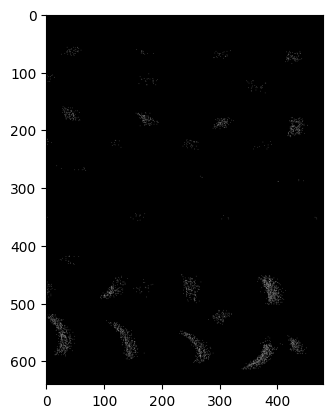

[[array([592, 372]), 2415, array([602, 374])], [array([573, 431]), 906, array([575, 429])], [array([477, 388]), 2739, array([464, 377])], [array([548,  25]), 2094, array([535,  25])], [array([575, 262]), 1814, array([563, 250])], [array([564, 138]), 2061, array([569, 137])], [array([ 66, 168]), 75, array([ 63, 165])], [array([173,  41]), 587, array([174,  43])], [array([189, 303]), 606, array([187, 302])], [array([196, 430]), 1026, array([190, 425])]]


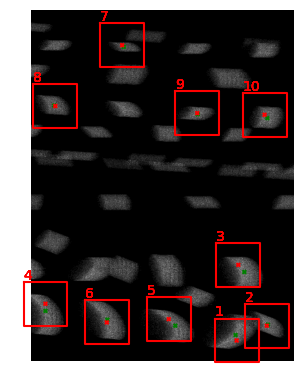

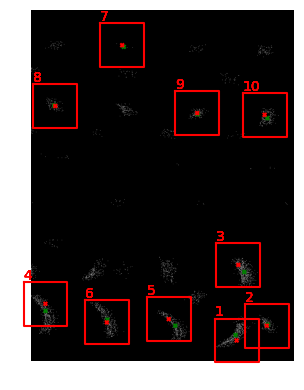

[[array([477, 390]), 8227, array([477, 388])], [array([590, 375]), 7778, array([592, 372])], [array([554,  27]), 8177, array([548,  25])], [array([566, 139]), 7809, array([564, 138])], [array([576, 262]), 6719, array([575, 262])], [array([196, 432]), 4493, array([196, 430])], [array([574, 433]), 3890, array([573, 431])], [array([188, 303]), 2662, array([189, 303])], [array([173,  42]), 3104, array([173,  41])], [array([ 69, 173]), 1285, array([ 66, 168])]]


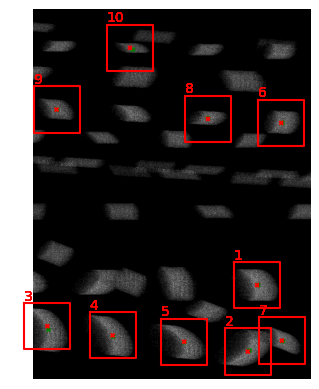

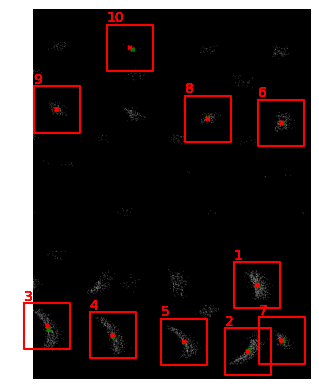

In [39]:
def plot_cluster(img, clusters, cluster_size):
    '''
    Plot the clusters on the image. 

        Parameters
        ----------
        img : numpy array
            Image to be filtered.
        clusters : list
                List of clusters. Each cluster is a list with the following structure:
                        [ [x_pixel, y_pixel], cluster comulative mass, inital cluster position [x_max, y_max] ]
        cluster_size : int
                Size of the square to be plotted around the cluster.

        Returns
        -------
        None.
    '''
    # Create figure and axes 
    fig, ax = plt.subplots()
    # Display the image
    ax.imshow(img, cmap='gray')

    # If the clusters are in the full cluster form [ [x_pixel, y_pixel], cluster comulative mass, inital cluster position [x_max, y_max] ]
    if len(clusters[1]) > 2:

        # Plot a square around the initial clusters position with size cluster_size
        for cluster in clusters:
                ax.plot([cluster[2][1] - cluster_size, cluster[2][1] - cluster_size, cluster[2][1] + cluster_size, cluster[2][1] + cluster_size, cluster[2][1] - cluster_size],
                        [cluster[2][0] - cluster_size, cluster[2][0] + cluster_size, cluster[2][0] + cluster_size, cluster[2][0] - cluster_size, cluster[2][0] - cluster_size], 'r')

        #     # Plot a square around the clusters with size cluster_size 
        #     for cluster in clusters:
        #         ax.plot([cluster[0][1] - cluster_size, cluster[0][1] - cluster_size, cluster[0][1] + cluster_size, cluster[0][1] + cluster_size, cluster[0][1] - cluster_size],
        #                 [cluster[0][0] - cluster_size, cluster[0][0] + cluster_size, cluster[0][0] + cluster_size, cluster[0][0] - cluster_size, cluster[0][0] - cluster_size], 'g', linestyle='dotted')
                
        # Plot the cluster number as text in the top left corner of the cluster
                for i, cluster in enumerate(clusters):
                        ax.text(cluster[2][1] - cluster_size, cluster[2][0] - cluster_size -5, i+1, color='r')

        # Plot a red green on the center of mass of the clusters
        for cluster in clusters:
                ax.plot([cluster[0][1] - 2, cluster[0][1] + 2],
                        [cluster[0][0] - 2, cluster[0][0] + 2], 'g')
                ax.plot([cluster[0][1] - 2, cluster[0][1] + 2],
                        [cluster[0][0] + 2, cluster[0][0] - 2], 'g')

        # Plot a red cross on the initial position of the clusters
        for cluster in clusters:
                ax.plot([cluster[2][1] - 2, cluster[2][1] + 2],
                        [cluster[2][0] - 2, cluster[2][0] + 2], 'r')
                ax.plot([cluster[2][1] - 2, cluster[2][1] + 2],
                        [cluster[2][0] + 2, cluster[2][0] - 2], 'r')
                
    # If cluster is only cluster position [x_pixel, y_pixel]
    elif len(clusters[1]) == 2:
        for cluster in clusters:
                # Plot a square around the initial clusters position with size cluster_size
                ax.plot([cluster[1] - cluster_size, cluster[1] - cluster_size, cluster[1] + cluster_size, cluster[1] + cluster_size, cluster[1] - cluster_size],
                        [cluster[0] - cluster_size, cluster[0] + cluster_size, cluster[0] + cluster_size, cluster[0] - cluster_size, cluster[0] - cluster_size], 'r')
                
                # Plot a red cross on the initial position of the clusters
                ax.plot([cluster[1] - 2, cluster[1] + 2],
                        [cluster[0] - 2, cluster[0] + 2], 'r')
                # Plot the cluster number as text in the top left corner of the cluster
                for i, cluster in enumerate(clusters):
                        ax.text(cluster[1] - cluster_size, cluster[0] - cluster_size -5, i+1, color='r')

    # Axis off
    ax.axis('off')
    # Show the plot
    plt.show()

#TODO: Ajustar brillo dinamicamente
max_pixel_value = np.max(frames[11])
treshold = round(max_pixel_value*0.5) # 50% of the max pixel value, MODIFY
print(treshold)


plot_image(treshold_filter(frames[11], treshold ))

clusters = max_value_cluster(treshold_filter(frames[11], treshold ), 40, 10)
print(clusters)
plot_cluster(frames[11], clusters, 40)
plot_cluster(treshold_filter(frames[11], treshold ), clusters, 40)


# Order the list of clusters by the value of the cluster mass
clusters = sorted(clusters, key=lambda x: x[1], reverse=True)
clusters_index = np.array([cluster[0] for cluster in clusters])
clusters = index_cluster(treshold_filter(frames[11], treshold-2 ), 40, clusters_index)
print(clusters)
plot_cluster(frames[11], clusters, 40)
plot_cluster(treshold_filter(frames[11], treshold ), clusters, 40)

In [5]:
clusters_batchs = []

for treshold in range(5,10):
    clusters = max_value_cluster(treshold_filter(frames[11], treshold ), 40, 10)
    clusters = sorted(clusters, key=lambda x: x[1], reverse=True)
    clusters_index = np.array([cluster[0] for cluster in clusters])
    clusters = index_cluster(treshold_filter(frames[11], treshold ), 40, clusters_index)
    clusters_batchs.append(clusters)

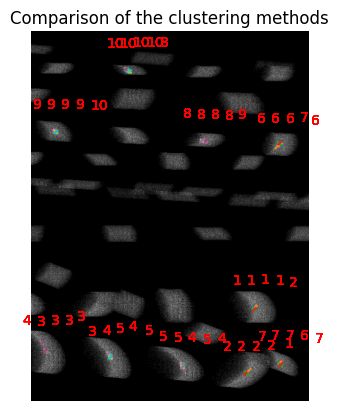

In [6]:
def plot_cluster_comparation(img, clusters_batchs, cluster_size):
    '''
    Plot the clusters on the image. 

        Parameters
        ----------
        img : numpy array
            Image to be filtered.
        clusters_batchs : list
                List of clusters. Each cluster is a list with the following structure:
                        [ [x_pixel, y_pixel], cluster comulative mass, inital cluster position [x_max, y_max] ]
        cluster_size : int
                Size of the square to be plotted around the cluster.

        Returns
        -------
        None.

    '''
    # Create figure and axes 
    fig, ax = plt.subplots()
    # Display the image
    ax.imshow(img, cmap='gray')
    
    spacing = 0 # Text spacing 

    # Plot a square around the initial clusters position with size cluster_size
    for clusters in clusters_batchs:
        
        for cluster in clusters:
            # ax.plot([cluster[2][1] - cluster_size, cluster[2][1] - cluster_size, cluster[2][1] + cluster_size, cluster[2][1] + cluster_size, cluster[2][1] - cluster_size],
            #         [cluster[2][0] - cluster_size, cluster[2][0] + cluster_size, cluster[2][0] + cluster_size, cluster[2][0] - cluster_size, cluster[2][0] - cluster_size], 'r')
    
        # Plot the cluster number as text in the top left corner of the cluster
            for i, cluster in enumerate(clusters):
                    ax.text(cluster[2][1] - cluster_size +spacing, cluster[2][0] - cluster_size , i+1, color='r')

        # Plot a red green on the center of mass of the clusters
        for cluster in clusters:
            ax.plot([cluster[0][1] - 2, cluster[0][1] + 2],
                    [cluster[0][0] - 2, cluster[0][0] + 2],)
            ax.plot([cluster[0][1] - 2, cluster[0][1] + 2],
                    [cluster[0][0] + 2, cluster[0][0] - 2],)
            
        spacing += 25

    ax.set_title('Comparison of the clustering methods')
    ax.axis('off')

    # Show the plot
    plt.show()
    
plot_cluster_comparation(frames[11], clusters_batchs, 40)


In [9]:
#Compute the pixel difference between the clusters position -> GET NOISE LEVEL
clusters_batchs = []

for treshold in range(5,10):
    clusters = max_value_cluster(treshold_filter(frames[11], treshold ), 40, 10)
# The cluster should mantain the position -> Not sorted by cluster mass
    clusters_index = np.array([cluster[0] for cluster in clusters])
    clusters = index_cluster(treshold_filter(frames[11], treshold ), 40, clusters_index)
    clusters_batchs.append(clusters)
    
av = 0
for i in range(len(clusters_batchs[:][1])):
    av += np.max([first[i][0] for first in clusters_batchs[:]], axis=0) - np.min(
        [first[i][0] for first in clusters_batchs[:]], axis=0)

av = av/len(clusters_batchs[:][1])
print(f"Mean pixel variation of the images [x ,y]: {av}")


Mean pixel variation of the images [x ,y]: [5.7 4.5]


63


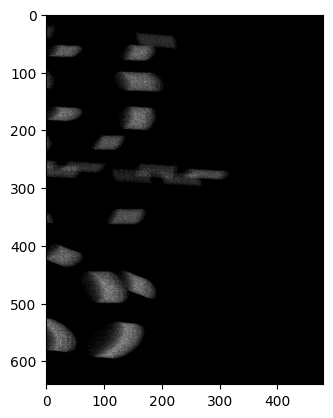

In [7]:
print(len(frames))
plot_image(frames[4])


## GET STAR FEATURES AND STAR CENTROID 

Image center:  [320. 240.]
Order by distance to the center of the image
Cluster 1 [array([188, 303]), 2662]: distance to center: 146.26346091898688
Cluster 2 [array([477, 390]), 8227]: distance to center: 217.13820483738002
Cluster 3 [array([196, 432]), 4493]: distance to center: 228.56071403458645
Cluster 4 [array([173,  42]), 3104]: distance to center: 246.60291969074495
Cluster 5 [array([576, 262]), 6719]: distance to center: 256.9435735720977
Cluster 6 [array([ 69, 173]), 1285]: distance to center: 259.7883754135277
Cluster 7 [array([566, 139]), 7809]: distance to center: 265.9266816248419
Cluster 8 [array([590, 375]), 7778]: distance to center: 301.8691769624716
Cluster 9 [array([554,  27]), 8177]: distance to center: 316.4253466459348
Cluster 10 [array([574, 433]), 3890]: distance to center: 319.00626953086675


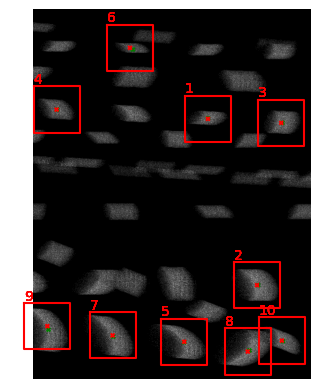

Main cluster:  [array([188, 303]), 2662]
Order by distance to the main cluster
[array([196, 432]), array([ 69, 173]), array([173,  42]), array([477, 390]), array([576, 262]), array([574, 433]), array([590, 375]), array([566, 139]), array([554,  27])]
Main cluster:  [array([477, 390]), 8227]
Order by distance to the main cluster
[array([574, 433]), array([590, 375]), array([576, 262]), array([566, 139]), array([196, 432]), array([554,  27]), array([173,  42]), array([ 69, 173])]


In [46]:
# Get order the cluster by closest to center of the image
def order_by_center_dist(clusters, img_shape):

    img_center = np.array(img_shape)/2
    clusters = sorted(clusters, key=lambda x: np.linalg.norm(x[0] - img_center), reverse=False)

    #Compute a list of each cluster distance 
    clusters_dist = []
    for cluster in clusters:
        clusters_dist.append(np.linalg.norm(cluster[0] - img_center))
    clusters_dist = np.array(clusters_dist)

    return clusters, clusters_dist

def order_by_main_dist(main_cluster, clusters):
    '''
    Order the clusters by distance to the main cluster
    
    Parameters
    ----------
    main_cluster : list
        List with the following structure:
        [ [x_pixel, y_pixel], cluster comulative mass, inital cluster position [x_max, y_max] ]
    clusters : list
        List of clusters. Each cluster is a list with the following structure:
        [ [x_pixel, y_pixel], cluster comulative mass, inital cluster position [x_max, y_max] ]
        
    Returns
    -------
    clusters : list
        List of clusters. Each cluster is a list with the following structure:
        [ [x_pixel, y_pixel], cluster comulative mass, inital cluster position [x_max, y_max] ]
            '''
    
    # Order the clusters by distance to the main cluster
    clusters = sorted(clusters, key=lambda x: np.linalg.norm(x[0] - main_cluster[0]), reverse=False)

    return clusters

# Pop last value of each cluster (Previous cluster position)
# if len(clusters[0]) == 3:
    # [cluster.pop() for cluster in clusters]

# Get the clusters that are closest to the center of the image
clusters_sort, clusters_dist= order_by_center_dist([cluster for cluster in clusters ], frames[11].shape)

print('Image center: ', np.array(frames[11].shape)/2)
print('Order by distance to the center of the image')
for i in range(len(clusters_sort)):
    print(f"Cluster {i+1} {clusters_sort[i][:2]}: distance to center: {clusters_dist[i]}")
# Plot the clusters on the image.
plot_cluster(frames[11], clusters_sort, 40)

for i in range(2):
    print('Main cluster: ', clusters_sort[i][:2])
    print('Order by distance to the main cluster')
    clusters_sort2 = order_by_main_dist(clusters_sort[i], clusters_sort[i+1:])
    print([cluster[0] for cluster in clusters_sort2])

In [45]:
def get_star_features(star_list):
    ''' 
       Compute the star features for the first star of the list. The star list shoud be ordered by the 
       distance to the first star. 

       Parameters
       ----------
         star_list : list
              List of stars. Each star is a list with the following structure:
                [main_star[x_pixel, y_pixel], first_neirbour_star[x_pixel, y_pixel], second_neirbour_star[x_pixel, y_pixel], ...]
        
        Returns
        -------
        stars_features_1 : list
            List of the features 1 of each star. Each feature is a list with the following structure:
                [x_pixel, y_pixel]
        stars_features_2 : list
            List of the features 2 of each star. Each feature is a list with the following structure:
                [x_pixel, y_pixel]


    '''  
    star_features_1 = []
    star_features_2 = []

    # Compute the x and y distance between the each star and the rest of the stars
    for j in range(1,len(star_list)):
            # x and y distance between the stars
            star_features_1.append(star_list[j][0] - star_list[0][0])
            star_features_1.append(star_list[j][1] - star_list[0][1])

    for j in range(len(star_list)):
        # Compute distance btwen each neirbour star (permutation)
        for k in range(j+1,len(star_list)):
            star_features_2.append( np.linalg.norm(star_list[k] - star_list[j]) )


    return star_features_1, star_features_2

test_stars =[ [3.10, 2.27],
              [3.46, 3.07],
              [2.96, 4.76],
              [5.02, 4.31],
              [6.82, 4.20]]
test_stars = np.array(test_stars)

test_sol_1 = [0.35935278000000004, 0.79855112, -0.14201749999999969, 2.4811158399999997, 1.9239419399999997, 2.04013278, 3.7215494400000004, 1.92897]
test_sol_2 = [0.8756816269324044, 2.4851770121673735, 2.8042279416127163, 4.191760429135272, 1.7556754240621915, 1.9973643278175017, 3.5471415569124973, 2.1124995779720463, 3.902821354929056, 1.80104133426015]
features_1, features_2 = get_star_features(test_stars)


print('Features 1 len: ',len(features_1), ', Features 2 len: ', len(features_2))
print('Main star: ', test_stars[0]) 
print('Features 1: ', features_1)
print('Features 2: ', features_2)

# for i in range(len(features_1)):
#     print(f"Star posistion {test_stars[i]}  features: {features_1[i]}")
#     print(f"    features 1: {features_1[i]}")
#     print(f"    features 2: {features_2[i]}")

print('Test error 1:', np.array(test_sol_1) - np.array(features_1))
print('Test error 2:', np.array(test_sol_2) - np.array(features_2))


Features 1 len:  8 , Features 2 len:  10
Main star:  [3.1  2.27]
Features 1:  [0.3599999999999999, 0.7999999999999998, -0.14000000000000012, 2.4899999999999998, 1.9199999999999995, 2.0399999999999996, 3.72, 1.9300000000000002]
Features 2:  [0.8772684879784521, 2.4939326374222697, 2.8014282071828998, 4.190859100470929, 1.7624131184259835, 1.9927869931329836, 3.5449259512717615, 2.108577719696383, 3.90041023483428, 1.8033579788827292]
Test error 1: [-0.00064722 -0.00144888 -0.0020175  -0.00888416  0.00394194  0.00013278
  0.00154944 -0.00103   ]
Test error 2: [-0.00158686 -0.00875563  0.00279973  0.00090133 -0.00673769  0.00457733
  0.00221561  0.00392186  0.00241112 -0.00231664]


[[array([188, 303]), 2662, array([189, 303])], [array([196, 432]), 4493, array([196, 430])], [array([ 69, 173]), 1285, array([ 66, 168])], [array([173,  42]), 3104, array([173,  41])], [array([477, 390]), 8227, array([477, 388])], [array([576, 262]), 6719, array([575, 262])], [array([574, 433]), 3890, array([573, 431])], [array([590, 375]), 7778, array([592, 372])], [array([566, 139]), 7809, array([564, 138])], [array([554,  27]), 8177, array([548,  25])]]
Features 1 len:  8 , Features 2 len:  10
Main star:  [188 303]
Features 1:  [289, 87, 8, 129, -15, -261, 388, -41]
Features 2:  [301.8111992620552, 129.24782396620841, 261.43067914841214, 390.16022349798806, 284.1214529035075, 462.0822437618654, 161.8177987738061, 390.6776164563309, 416.293165929973, 459.1394123792903]


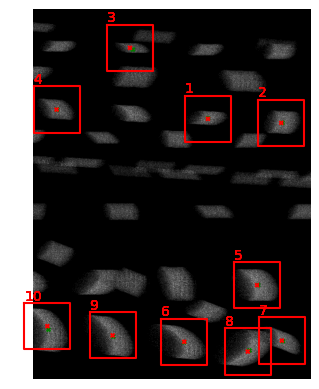

In [66]:
# Get the features of the selected main star 

main_star = clusters_sort[0]
stars_sorted_by_main = order_by_main_dist(main_star, clusters_sort)
print(stars_sorted_by_main)

num_of_neirbours = 4
stars_features_1, stars_features_2 = get_star_features([star[0] for star in clusters_sort[0:num_of_neirbours+1]])
print('Features 1 len: ',len(stars_features_1), ', Features 2 len: ', len(stars_features_2))
print('Main star: ', clusters_sort[0][0])
print('Features 1: ', stars_features_1)
print('Features 2: ', stars_features_2)
plot_cluster(frames[11], stars_sorted_by_main, 40)


array([320., 240.])

In [79]:
#Get the image postion
star_postion = np.array([60,80]) #EXAMPLE -> GET FROM SOM

img_center = np.array(frames[11].shape)/2
pixel_to_deg = 0.03 #EXAMPLE

print('Main star: ', main_star[0])
distance_to_center = main_star[0] - img_center
print('Pixel distance to center: ', distance_to_center)
print('Distance to center: ', distance_to_center*pixel_to_deg)
print('Camera position: ', star_postion + distance_to_center*pixel_to_deg)

Main star:  [188 303]
Pixel distance to center:  [-132.   63.]
Distance to center:  [-3.96  1.89]
Camera position:  [56.04 81.89]
